### Fz-Oz Connectivity alpha band

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, pearsonr
import mne

# -------------------------------
# Configuration
# -------------------------------
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
PARTICIPANTS_CSV = os.path.join(BASE_DIR, "participants.csv")  # adjust if needed
BAND = "alpha"

# Channels to test (frontal -> occipital)
CH_1 = "Fz"
CH_2 = "Oz"

# MoCA threshold: >=26 = unimpaired, <26 = impaired
MOCA_THRESHOLD = 26

# -------------------------------
# Utilities
# -------------------------------
def get_channel_indices(subj, ch1_name, ch2_name):
    epo_file = os.path.join(BASE_DIR, subj, f"epo_{subj[-3:]}_raw.fif")
    if not os.path.exists(epo_file):
        raise FileNotFoundError(f"{subj}: epochs file missing ({epo_file})")
    epochs = mne.read_epochs(epo_file, preload=False, verbose=False)
    ch_names = [c.upper() for c in epochs.ch_names]
    try:
        return ch_names.index(ch1_name.upper()), ch_names.index(ch2_name.upper())
    except ValueError:
        raise ValueError(f"{subj}: {ch1_name} or {ch2_name} not found in channels")

def load_pli_map(subjects, band="alpha", ch1=CH_1, ch2=CH_2):
    """
    Return dict {subj: pli_value} for subjects where a valid value exists.
    """
    pli_map = {}
    for subj in subjects:
        pli_path = os.path.join(BASE_DIR, subj, "data", f"{subj}_{band}_pli_matrix.npy")
        if not os.path.exists(pli_path):
            # print(f"{subj}: missing PLI file")
            continue
        mat = np.load(pli_path)
        # Symmetrize if triangular (common storage quirk)
        if np.allclose(mat, np.tril(mat)) or np.allclose(mat, np.triu(mat)):
            mat = mat + mat.T
        # require square matrix
        if mat.ndim != 2 or mat.shape[0] != mat.shape[1]:
            # print(f"{subj}: invalid PLI matrix shape {mat.shape}")
            continue
        try:
            idx1, idx2 = get_channel_indices(subj, ch1, ch2)
        except Exception:
            # print(e)
            continue
        if idx1 >= mat.shape[0] or idx2 >= mat.shape[0]:
            # print(f"{subj}: channel index out of range for {mat.shape[0]} channels")
            continue
        val = mat[idx1, idx2]
        # fallback to symmetric position
        if (val == 0 or not np.isfinite(val)) and idx1 != idx2:
            val = mat[idx2, idx1]
        if not np.isfinite(val):
            continue
        pli_map[subj] = float(val)
    return pli_map

# -------------------------------
# Load participants and PD MoCA
# -------------------------------
if not os.path.exists(PARTICIPANTS_CSV):
    raise FileNotFoundError(f"participants CSV not found at {PARTICIPANTS_CSV}")

df = pd.read_csv(PARTICIPANTS_CSV, dtype={"participant_id": str})
df.set_index("participant_id", inplace=True)

# Filter PD subjects (only PD)
pd_df = df[df["GROUP"].str.upper() == "PD"].copy()
pd_subjects = pd_df.index.tolist()

# Load PLI map for PD subjects
pli_map = load_pli_map(pd_subjects, band=BAND, ch1=CH_1, ch2=CH_2)
if len(pli_map) == 0:
    raise RuntimeError("No valid PLI values found for PD subjects. Check paths and files.")

# Build arrays aligning MoCA and PLI
rows = []
for subj, pli_val in pli_map.items():
    # read MoCA (may be NaN)
    try:
        moca = pd_df.at[subj, "MOCA"]
    except KeyError:
        continue
    # skip missing MoCA
    if pd.isna(moca):
        continue
    rows.append((subj, float(moca), pli_val))

if len(rows) == 0:
    raise RuntimeError("No PD subjects found with both MoCA and PLI present.")

rows_df = pd.DataFrame(rows, columns=["subj", "MOCA", "PLI"]).set_index("subj")

# -------------------------------
# Split by MoCA threshold: impaired (<26) vs unimpaired (>=26)
# -------------------------------
impaired_df = rows_df[rows_df["MOCA"] < MOCA_THRESHOLD]
unimpaired_df = rows_df[rows_df["MOCA"] >= MOCA_THRESHOLD]

print("\nCohort counts (PD only):")
print(f"  Total PD with MoCA+PLI: {len(rows_df)}")
print(f"  Impaired (MoCA < {MOCA_THRESHOLD}): {len(impaired_df)}")
print(f"  Unimpaired (MoCA >= {MOCA_THRESHOLD}): {len(unimpaired_df)}\n")

# Basic summaries
def summarize(group_df, name):
    if len(group_df) == 0:
        print(f"{name}: n=0")
        return
    print(f"{name}: n={len(group_df)} | PLI mean={group_df['PLI'].mean():.6f} std={group_df['PLI'].std():.6f} | MOCA mean={group_df['MOCA'].mean():.2f}")

summarize(impaired_df, "Impaired")
summarize(unimpaired_df, "Unimpaired")

# -------------------------------
# Statistical comparison: t-test (impaired vs unimpaired)
# -------------------------------
print("\n--- Group comparison (Impaired vs Unimpaired) ---")
if len(impaired_df) < 3 or len(unimpaired_df) < 3:
    print("Too few subjects in one of the groups to run reliable t-test.")
else:
    # check variance
    if impaired_df["PLI"].std() == 0 or unimpaired_df["PLI"].std() == 0:
        print("Zero variance detected in one group; t-test not appropriate.")
    else:
        t_stat, p_val = ttest_ind(impaired_df["PLI"].values,
                                 unimpaired_df["PLI"].values,
                                 equal_var=False)
        print(f"t = {t_stat:.3f}, p = {p_val:.6g}")

# -------------------------------
# Continuous association: Pearson correlation (PLI vs MOCA)
# -------------------------------
print("\n--- Correlation (PLI vs MOCA) across PD ---")
if len(rows_df) < 4:
    print("Too few paired observations for reliable correlation.")
else:
    r, p_corr = pearsonr(rows_df["PLI"].values, rows_df["MOCA"].values)
    print(f"Pearson r = {r:.3f}, p = {p_corr:.6g}")

# -------------------------------
# Output: save summary table (optional)
# -------------------------------
OUT_CSV = os.path.join(BASE_DIR, f"PD_PLI_MOCA_{CH_1}_{CH_2}_{BAND}.csv")
rows_df.to_csv(OUT_CSV)
print(f"\nSaved per-subject PLI+MOCA to: {OUT_CSV}")

ROIs = {
    'Frontal': ['Fp1', 'Fz', 'F3', 'F7', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz',
                 'F1','F5', 'F6', 'AF8', 'AF4', 'F2', 'FCz'],
    'Frontocentral': ['FT9', 'FC5', 'FC1', 'FT7', 'FC3', 'FC6', 'FC2', 'FT8'],
    'Central': ['C3', 'C1', 'C5', 'Cz', 'C4', 'C6', 'C2'],
    'Temporal': ['T7', 'TP9', 'TP7', 'T8', 'TP10', 'TP8'],
    'Parietal': ['CP5', 'CP1', 'CP3', 'CPz', 'CP6', 'CP2', 'P3', 'P7', 'P1',
                  'P5', 'P4', 'P8', 'P6', 'P2'],
    'Occipital': ['O1', 'Oz', 'O2', 'PO7', 'PO3', 'POz', 'PO4', 'PO8']
}


### Multi-band and channel connectivity versus MoCA.

In [3]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, pearsonr
import mne

# -------------------------------
# Config
# -------------------------------
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
PART_CSV = os.path.join(BASE_DIR, "participants.csv")
BANDS = {
    "delta": "delta",
    "theta": "theta",
    "alpha": "alpha",
    "beta": "beta"
}
CHANNEL_PAIRS = [
    ("Fz", "Oz"),
    ("Fz", "Pz"),
    ("Fp1", "Oz"),
    ("C3", "P3"),
    ("F3", "P4")
]
MOCA_THRESHOLD = 26

df = pd.read_csv(PART_CSV, dtype={"participant_id": str})
df.set_index("participant_id", inplace=True)
pd_df = df[df["GROUP"].str.upper() == "PD"]

def get_ch_indices(subj, ch1, ch2):
    epo_file = os.path.join(BASE_DIR, subj, f"epo_{subj[-3:]}_raw.fif")
    epochs = mne.read_epochs(epo_file, preload=False, verbose=False)
    chs = [c.upper() for c in epochs.ch_names]
    return chs.index(ch1.upper()), chs.index(ch2.upper())

def load_pair_pli(subj, band, ch1, ch2):
    path = os.path.join(BASE_DIR, subj, "data", f"{subj}_{band}_pli_matrix.npy")
    if not os.path.exists(path):
        return None
    mat = np.load(path)
    if mat.ndim != 2 or mat.shape[0] != mat.shape[1]:
        return None
    if np.allclose(mat, np.tril(mat)) or np.allclose(mat, np.triu(mat)):
        mat = mat + mat.T
    try:
        i1, i2 = get_ch_indices(subj, ch1, ch2)
    except Exception:
        return None
    if not (0 <= i1 < mat.shape[0] and 0 <= i2 < mat.shape[1]):
        return None
    val = mat[i1, i2]
    return float(val) if np.isfinite(val) else None

# -------------------------------
# Analysis per band and channel pair
# -------------------------------
results = []

for band_name in BANDS:
    for (ch1, ch2) in CHANNEL_PAIRS:
        # Collect PD PLI + MoCA
        rows = []
        for subj in pd_df.index:
            pli_val = load_pair_pli(subj, band_name, ch1, ch2)
            if pli_val is None:
                continue
            moca = pd_df.at[subj, "MOCA"]
            if pd.isna(moca):
                continue
            rows.append((subj, float(moca), pli_val))
        if not rows:
            continue

        table = pd.DataFrame(rows, columns=["subj", "MOCA", "PLI"]).set_index("subj")
        impaired = table[table["MOCA"] < MOCA_THRESHOLD]
        unimpaired = table[table["MOCA"] >= MOCA_THRESHOLD]

        # t-test
        if len(impaired) >= 3 and len(unimpaired) >= 3:
            t_stat, p_group = ttest_ind(impaired["PLI"].values,
                                       unimpaired["PLI"].values,
                                       equal_var=False)
        else:
            p_group = np.nan

        # correlation
        if len(table) >= 4:
            r, p_corr = pearsonr(table["PLI"].values, table["MOCA"].values)
        else:
            p_corr = np.nan

        results.append({
            "band": band_name,
            "pair": f"{ch1}-{ch2}",
            "n_total": len(table),
            "n_impaired": len(impaired),
            "n_unimpaired": len(unimpaired),
            "p_group": p_group,
            "p_corr": p_corr
        })

# results table
res_df = pd.DataFrame(results)
print(res_df)
res_df.to_csv(os.path.join(BASE_DIR, "PD_Cognition_Connectivity_Results.csv"))
print("Saved results to PD_Cognition_Connectivity_Results.csv")
from scipy.stats import ttest_ind, pearsonr, spearmanr  # <-- add spearmanr

# -------------------------------
# Analysis per band and channel pair
# -------------------------------
results = []

for band_name in BANDS:
    for (ch1, ch2) in CHANNEL_PAIRS:
        # Collect PD PLI + MoCA
        rows = []
        for subj in pd_df.index:
            pli_val = load_pair_pli(subj, band_name, ch1, ch2)
            if pli_val is None:
                continue
            moca = pd_df.at[subj, "MOCA"]
            if pd.isna(moca):
                continue
            rows.append((subj, float(moca), pli_val))
        if not rows:
            continue

        table = pd.DataFrame(rows, columns=["subj", "MOCA", "PLI"]).set_index("subj")
        impaired = table[table["MOCA"] < MOCA_THRESHOLD]
        unimpaired = table[table["MOCA"] >= MOCA_THRESHOLD]

        # t-test
        if len(impaired) >= 3 and len(unimpaired) >= 3:
            t_stat, p_group = ttest_ind(impaired["PLI"].values,
                                       unimpaired["PLI"].values,
                                       equal_var=False)
        else:
            p_group = np.nan

        # Pearson correlation
        if len(table) >= 4:
            r_pearson, p_pearson = pearsonr(table["PLI"].values, table["MOCA"].values)
        else:
            r_pearson, p_pearson = np.nan, np.nan

        # Spearman correlation
        if len(table) >= 4:
            r_spear, p_spear = spearmanr(table["PLI"].values, table["MOCA"].values)
        else:
            r_spear, p_spear = np.nan, np.nan

        results.append({
            "band": band_name,
            "pair": f"{ch1}-{ch2}",
            "n_total": len(table),
            "n_impaired": len(impaired),
            "n_unimpaired": len(unimpaired),
            "p_group": p_group,
            "pearson_r": r_pearson,
            "pearson_p": p_pearson,
            "spearman_r": r_spear,
            "spearman_p": p_spear
        })

# results table
res_df = pd.DataFrame(results)
print(res_df)
res_df.to_csv(os.path.join(BASE_DIR, "PD_Cognition_Connectivity_Results.csv"), index=False)
print("Saved results to PD_Cognition_Connectivity_Results.csv")



C:\Users\User\AppData\Local\Temp\ipykernel_3948\2178981322.py:33: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-001\epo_001_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_file, preload=False, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_3948\2178981322.py:33: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-002\epo_002_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_file, preload=False, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_3948\2178981322.py:33: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-003\epo_003_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epo

     band    pair  n_total  n_impaired  n_unimpaired   p_group    p_corr
0   delta   Fz-Oz      100          53            47  0.914054  0.738107
1   delta  Fp1-Oz      100          53            47  0.416000  0.490161
2   delta   C3-P3      100          53            47  0.834704  0.770565
3   delta   F3-P4      100          53            47  0.624914  0.221001
4   theta   Fz-Oz      100          53            47  0.418169  0.020906
5   theta  Fp1-Oz      100          53            47  0.742500  0.121453
6   theta   C3-P3      100          53            47  0.432834  0.617089
7   theta   F3-P4      100          53            47  0.863801  0.658334
8   alpha   Fz-Oz      100          53            47  0.658436  0.945696
9   alpha  Fp1-Oz      100          53            47  0.463044  0.215210
10  alpha   C3-P3      100          53            47  0.723527  0.052631
11  alpha   F3-P4      100          53            47  0.810540  0.689681
12   beta   Fz-Oz      100          53            4

C:\Users\User\AppData\Local\Temp\ipykernel_3948\2178981322.py:33: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-001\epo_001_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_file, preload=False, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_3948\2178981322.py:33: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-002\epo_002_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_file, preload=False, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_3948\2178981322.py:33: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-003\epo_003_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epo

     band    pair  n_total  n_impaired  n_unimpaired   p_group  pearson_r  \
0   delta   Fz-Oz      100          53            47  0.914054   0.033852   
1   delta  Fp1-Oz      100          53            47  0.416000  -0.069799   
2   delta   C3-P3      100          53            47  0.834704   0.029528   
3   delta   F3-P4      100          53            47  0.624914   0.123471   
4   theta   Fz-Oz      100          53            47  0.418169  -0.230743   
5   theta  Fp1-Oz      100          53            47  0.742500  -0.155882   
6   theta   C3-P3      100          53            47  0.432834   0.050602   
7   theta   F3-P4      100          53            47  0.863801   0.044762   
8   alpha   Fz-Oz      100          53            47  0.658436   0.006898   
9   alpha  Fp1-Oz      100          53            47  0.463044   0.125021   
10  alpha   C3-P3      100          53            47  0.723527   0.194385   
11  alpha   F3-P4      100          53            47  0.810540   0.040421   

C:\Users\User\AppData\Local\Temp\ipykernel_3948\2178981322.py:33: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-100\epo_100_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_file, preload=False, verbose=False)


### FRONTAL POSTERIOR BETA CONNECTIVITY

In [2]:
import os
import numpy as np
import mne
from scipy.stats import ttest_ind, pearsonr
import pandas as pd

# -------------------------------
# Configuration
# -------------------------------
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
BAND = "beta"

# Frontal and Posterior channels
FRONTAL_CH = ['Fp1', 'Fz', 'F3', 'F7', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'F6', 'AF8', 'AF4', 'F2',]
POSTERIOR_CH = ['P3','P4','P7','P8','O1','O2','Oz']

# Load subject info
meta = pd.read_csv(r'C:\Users\User\Documents\EEG_Project\rEEG\participants.csv')  # must have columns: participant_id, MOCA

# Only PD subjects
PD_SUBS = meta.loc[meta['GROUP']=='PD', 'participant_id'].tolist()

# -------------------------------
# Helper: get channel indices
# -------------------------------
def get_channel_indices(subj):
    epo_file = os.path.join(BASE_DIR, subj, f"epo_{subj[-3:]}_raw.fif")
    if not os.path.exists(epo_file):
        raise FileNotFoundError(f"{subj}: epochs file missing")
    epochs = mne.read_epochs(epo_file, preload=False, verbose=False)
    ch_names = [ch.upper() for ch in epochs.ch_names]
    idx_F = [ch_names.index(ch.upper()) for ch in FRONTAL_CH if ch.upper() in ch_names]
    idx_P = [ch_names.index(ch.upper()) for ch in POSTERIOR_CH if ch.upper() in ch_names]
    return idx_F, idx_P

# -------------------------------
# Load and extract edge values
# -------------------------------
edge_data = {}  # subject_id -> edge matrix

for subj in PD_SUBS:
    path = os.path.join(BASE_DIR, subj, "data", f"{subj}_{BAND}_pli_matrix.npy")
    if not os.path.exists(path):
        print(f"{subj}: missing PLI file")
        continue
    mat = np.load(path)

    # Symmetrize triangular matrices
    if np.allclose(mat, np.tril(mat)) or np.allclose(mat, np.triu(mat)):
        mat = mat + mat.T

    try:
        idx_F, idx_P = get_channel_indices(subj)
    except Exception as e:
        print(e)
        continue

    # Extract frontal–posterior submatrix
    F_P_mat = mat[np.ix_(idx_F, idx_P)]
    edge_data[subj] = F_P_mat

# -------------------------------
# Aggregate for group analysis
# -------------------------------
agg_vals = []
labels = []
moca_vals_list = []

for subj, edges in edge_data.items():
    # get MoCA
    moca_vals = meta.loc[meta['participant_id'] == subj, 'MOCA'].values
    if len(moca_vals) == 0 or np.isnan(moca_vals[0]):
        print(f"{subj}: missing MoCA, skipping")
        continue
    moca = moca_vals[0]

    mean_conn = np.mean(edges)
    agg_vals.append(mean_conn)
    labels.append(1 if moca < 26 else 0)  # 1 = impaired, 0 = unimpaired
    moca_vals_list.append(moca)

agg_vals = np.array(agg_vals)
labels = np.array(labels)
moca_vals_list = np.array(moca_vals_list)

# Split
impaired = agg_vals[labels == 1]
unimpaired = agg_vals[labels == 0]

# -------------------------------
# Stats
# -------------------------------
t, p = ttest_ind(impaired, unimpaired, equal_var=False)
r, p_corr = pearsonr(agg_vals, moca_vals_list)
print(f'{BAND} FRONTAL-POSTERIOR CONNECTIVITY')
print(f"Cohort counts (PD only):")
print(f"  Total PD with MoCA+PLI: {len(agg_vals)}")
print(f"  Impaired (MoCA <26): {len(impaired)}")
print(f"  Unimpaired (MoCA >=26): {len(unimpaired)}\n")

print(f"Impaired: n={len(impaired)} | PLI mean={impaired.mean():.6f} std={impaired.std():.6f}")
print(f"Unimpaired: n={len(unimpaired)} | PLI mean={unimpaired.mean():.6f} std={unimpaired.std():.6f}\n")

print(f"--- Group comparison (Impaired vs Unimpaired) ---")
print(f"t = {t:.3f}, p = {p:.6g}")

print(f"\n--- Correlation (PLI vs MoCA) across PD ---")
print(f"Pearson r = {r:.3f}, p = {p_corr:.6g}")

# -------------------------------
# Optional: Save edge-level data for later
# -------------------------------
np.save("PD_FrontPosterior_beta_edge_data.npy", edge_data)


C:\Users\User\AppData\Local\Temp\ipykernel_44848\1517946630.py:30: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-001\epo_001_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_file, preload=False, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_44848\1517946630.py:30: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-002\epo_002_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_file, preload=False, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_44848\1517946630.py:30: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-003\epo_003_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  

beta FRONTAL-POSTERIOR CONNECTIVITY
Cohort counts (PD only):
  Total PD with MoCA+PLI: 100
  Impaired (MoCA <26): 53
  Unimpaired (MoCA >=26): 47

Impaired: n=53 | PLI mean=0.103337 std=0.014150
Unimpaired: n=47 | PLI mean=0.112486 std=0.018513

--- Group comparison (Impaired vs Unimpaired) ---
t = -2.722, p = 0.00787051

--- Correlation (PLI vs MoCA) across PD ---
Pearson r = 0.249, p = 0.0125055


C:\Users\User\AppData\Local\Temp\ipykernel_57628\4204506308.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x='Group', y='Beta_PLI', inner=None, palette="muted", ax=axes[0], alpha=0.3)


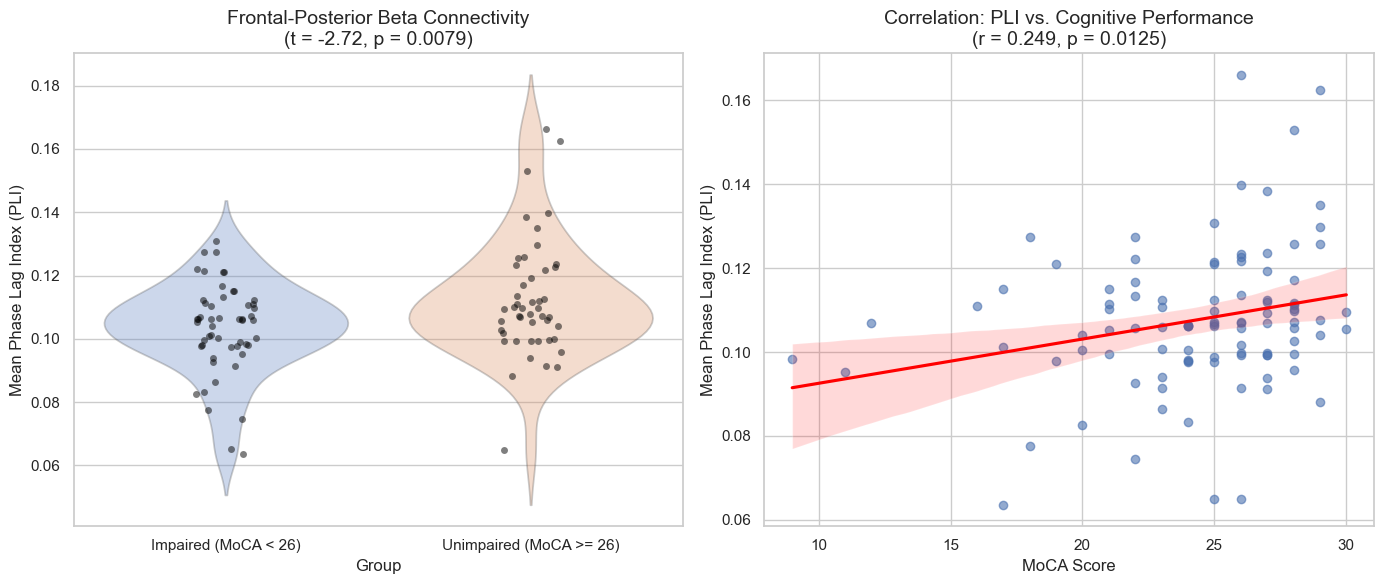

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Create a temporary DataFrame for plotting
plot_df = pd.DataFrame({
    'Beta_PLI': agg_vals,
    'MoCA_Score': moca_vals_list,
    'Group': ['Impaired (MoCA < 26)' if l == 1 else 'Unimpaired (MoCA >= 26)' for l in labels]
})

# Set the visual style
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Panel A: Group Comparison ---
# A violin plot shows the distribution density + individual points
sns.violinplot(data=plot_df, x='Group', y='Beta_PLI', inner=None, palette="muted", ax=axes[0], alpha=0.3)
sns.stripplot(data=plot_df, x='Group', y='Beta_PLI', color="black", alpha=0.5, ax=axes[0])
axes[0].set_title(f"Frontal-Posterior {BAND.capitalize()} Connectivity\n(t = {t:.2f}, p = {p:.4f})", fontsize=14)
axes[0].set_ylabel("Mean Phase Lag Index (PLI)")

# --- Panel B: Continuous Correlation ---
# A regression plot shows the trend line and 95% confidence interval
sns.regplot(data=plot_df, x='MoCA_Score', y='Beta_PLI', ax=axes[1], 
            scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
axes[1].set_title(f"Correlation: PLI vs. Cognitive Performance\n(r = {r:.3f}, p = {p_corr:.4f})", fontsize=14)
axes[1].set_xlabel("MoCA Score")
axes[1].set_ylabel("Mean Phase Lag Index (PLI)")

plt.tight_layout()
plt.savefig("PD_Beta_Connectivity_Results.png", dpi=300)
plt.show()

In [5]:
import numpy as np

# Example: your PLI values and labels
agg_vals = np.array(agg_vals)          # Beta_PLI values
labels = np.array(labels)              # 1 = Impaired, 0 = Unimpaired

# Separate groups
group1 = agg_vals[labels == 1]  # Impaired
group2 = agg_vals[labels == 0]  # Unimpaired

# Compute means and standard deviations
mean1, mean2 = np.mean(group1), np.mean(group2)
std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
n1, n2 = len(group1), len(group2)

# Pooled standard deviation
pooled_std = np.sqrt(((n1 - 1)*std1**2 + (n2 - 1)*std2**2) / (n1 + n2 - 2))

# Cohen's d
cohens_d = (mean1 - mean2) / pooled_std

print(f"Cohen's d = {cohens_d:.3f}")

# -------------------------------
# Benjamini-Hochberg FDR Correction
# -------------------------------
from statsmodels.stats.multitest import multipletests

raw_pvals = [p, p_corr]
test_names = ["t-test (impaired vs unimpaired)", "Pearson r (PLI vs MoCA)"]

reject, pvals_corrected, _, _ = multipletests(raw_pvals, alpha=0.05, method='fdr_bh')

print(f"\n--- BH FDR Correction ")
for name, raw, corrected, rej in zip(test_names, raw_pvals, pvals_corrected, reject):
    print(f"{name}: raw p={raw:.6g} | FDR-corrected p={corrected:.6g} | significant={rej}")


Cohen's d = -0.554

--- BH FDR Correction 
t-test (impaired vs unimpaired): raw p=0.00787051 | FDR-corrected p=0.0125055 | significant=True
Pearson r (PLI vs MoCA): raw p=0.0125055 | FDR-corrected p=0.0125055 | significant=True


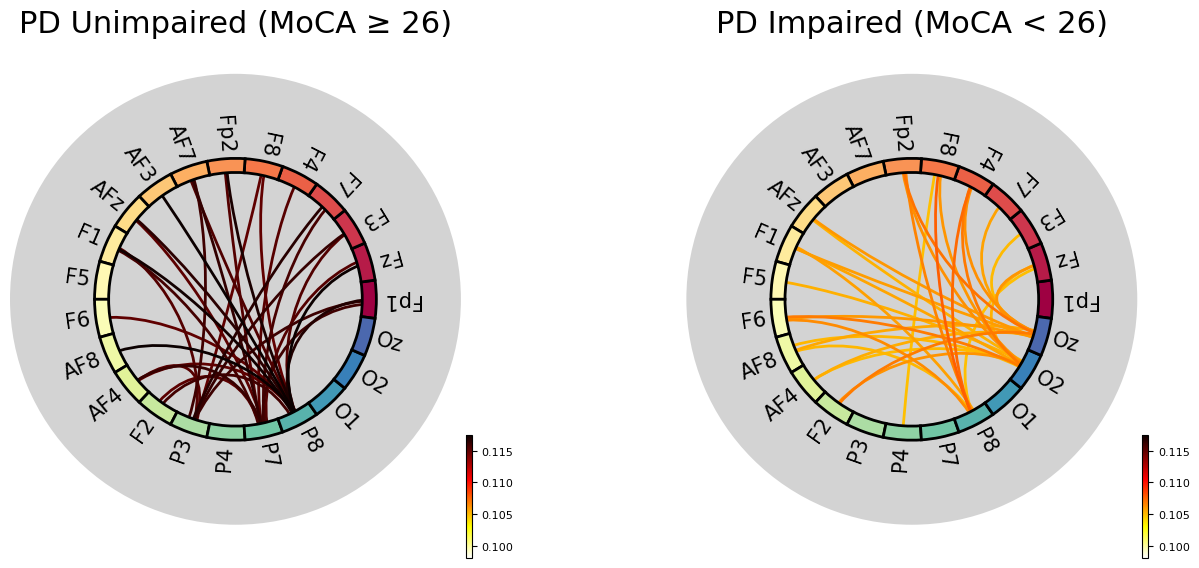

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from mne_connectivity.viz import plot_connectivity_circle

# --------------------------------------------------
# Node labels
# --------------------------------------------------
FRONTAL_CH = ['Fp1', 'Fz', 'F3', 'F7', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'F6', 'AF8', 'AF4', 'F2',]
POSTERIOR_CH = ['P3','P4','P7','P8','O1','O2','Oz']

node_names = FRONTAL_CH + POSTERIOR_CH

# --------------------------------------------------
# Build group-averaged connectivity matrices
# --------------------------------------------------
def get_avg_full_mat(group_label):
    if group_label == 1:  # Impaired
        subjs = [s for s in edge_data
                 if meta.loc[meta['participant_id'] == s, 'MOCA'].values[0] < 26]
    else:  # Unimpaired
        subjs = [s for s in edge_data
                 if meta.loc[meta['participant_id'] == s, 'MOCA'].values[0] >= 26]

    if not subjs:
        return np.zeros((len(node_names), len(node_names)))

    avg_f_p = np.mean([edge_data[s] for s in subjs], axis=0)

    full_mat = np.zeros((len(node_names), len(node_names)))
    n_frontal = len(FRONTAL_CH)
    full_mat[:n_frontal, n_frontal:] = avg_f_p

    return full_mat + full_mat.T


# --------------------------------------------------
# Compute contrast scale from group-level data
# --------------------------------------------------
group_mats = []
for lab in [0, 1]:
    mat = get_avg_full_mat(lab)
    group_mats.append(mat[mat > 0])   # ignore zeros

all_vals = np.concatenate(group_mats)

vmin = np.percentile(all_vals, 0)    # median
vmax = np.percentile(all_vals, 99)    # upper tail

# --------------------------------------------------
# Plot
# --------------------------------------------------
fig, axes = plt.subplots(
    1, 2,
    figsize=(16, 8),
    facecolor='white',
    subplot_kw=dict(polar=True)
)

for i, lab in enumerate([0, 1]):
    title_str = "PD Unimpaired (MoCA ≥ 26)" if lab == 0 else "PD Impaired (MoCA < 26)"
    mat_to_plot = get_avg_full_mat(lab)

    plot_connectivity_circle(
        mat_to_plot,
        node_names,
        n_lines=30,
        title=title_str,
        ax=axes[i],
        show=False,
        colormap='hot_r',
        vmin=vmin,
        fontsize_names=15,
        linewidth=2,
        vmax=vmax,
        textcolor='black',        # Sets electrode names to black
        facecolor='lightgray',       # Keep background white
        fontsize_title=22        # Increase title size here
    )
    
    # Manually set the title color to white
    axes[i].set_title(title_str, color='black', fontsize=22, pad=30)

In [5]:
# Quantify Strength for each Hub
frontal_strength_impaired = []
frontal_strength_unimpaired = []

for subj, edges in edge_data.items():
    # edges is an (idx_F x idx_P) matrix
    # Summing across the posterior axis gives the total connectivity for each frontal node
    frontal_node_strength = np.mean(edges, axis=1) # Mean strength per frontal channel
    total_frontal_contribution = np.mean(frontal_node_strength)
    
    moca = meta.loc[meta['participant_id'] == subj, 'MOCA'].values[0]
    if moca < 26:
        frontal_strength_impaired.append(total_frontal_contribution)
    else:
        frontal_strength_unimpaired.append(total_frontal_contribution)

print(f"Frontal Hub Strength (Impaired): {np.mean(frontal_strength_impaired):.4f}")
print(f"Frontal Hub Strength (Unimpaired): {np.mean(frontal_strength_unimpaired):.4f}")
# Define a threshold (e.g., the 75th percentile of all PLI values)
threshold = np.percentile(agg_vals, 50)

def count_strong_edges(subj_edges, thresh):
    return np.sum(subj_edges > thresh)

edge_counts = {subj: count_strong_edges(edges, threshold) for subj, edges in edge_data.items()}

# Compare the average number of "strong" connections
impaired_counts = [edge_counts[s] for s in edge_data if meta.loc[meta['participant_id']==s, 'MOCA'].values[0] < 26]
unimpaired_counts = [edge_counts[s] for s in edge_data if meta.loc[meta['participant_id']==s, 'MOCA'].values[0] >= 26]

print(f"Avg Strong Edges (Impaired): {np.mean(impaired_counts):.2f}")
print(f"Avg Strong Edges (Unimpaired): {np.mean(unimpaired_counts):.2f}")

from scipy.stats import ttest_ind

# --- Frontal Hub Strength ---
t_strength, p_strength = ttest_ind(frontal_strength_impaired, frontal_strength_unimpaired, equal_var=False)
mean_diff_strength = np.mean(frontal_strength_impaired) - np.mean(frontal_strength_unimpaired)
pooled_sd_strength = np.sqrt((np.std(frontal_strength_impaired, ddof=1)**2 + np.std(frontal_strength_unimpaired, ddof=1)**2)/2)
cohen_d_strength = mean_diff_strength / pooled_sd_strength

print(f"Frontal Hub Strength: t={t_strength:.3f}, p={p_strength:.4g}, Cohen's d={cohen_d_strength:.3f}")

# --- Strong Edge Counts ---
t_edges, p_edges = ttest_ind(impaired_counts, unimpaired_counts, equal_var=False)
mean_diff_edges = np.mean(impaired_counts) - np.mean(unimpaired_counts)
pooled_sd_edges = np.sqrt((np.std(impaired_counts, ddof=1)**2 + np.std(unimpaired_counts, ddof=1)**2)/2)
cohen_d_edges = mean_diff_edges / pooled_sd_edges

print(f"Strong Edge Counts: t={t_edges:.3f}, p={p_edges:.4g}, Cohen's d={cohen_d_edges:.3f}")

Frontal Hub Strength (Impaired): 0.1033
Frontal Hub Strength (Unimpaired): 0.1125
Avg Strong Edges (Impaired): 46.34
Avg Strong Edges (Unimpaired): 58.57
Frontal Hub Strength: t=-2.722, p=0.007871, Cohen's d=-0.550
Strong Edge Counts: t=-1.865, p=0.06521, Cohen's d=-0.373


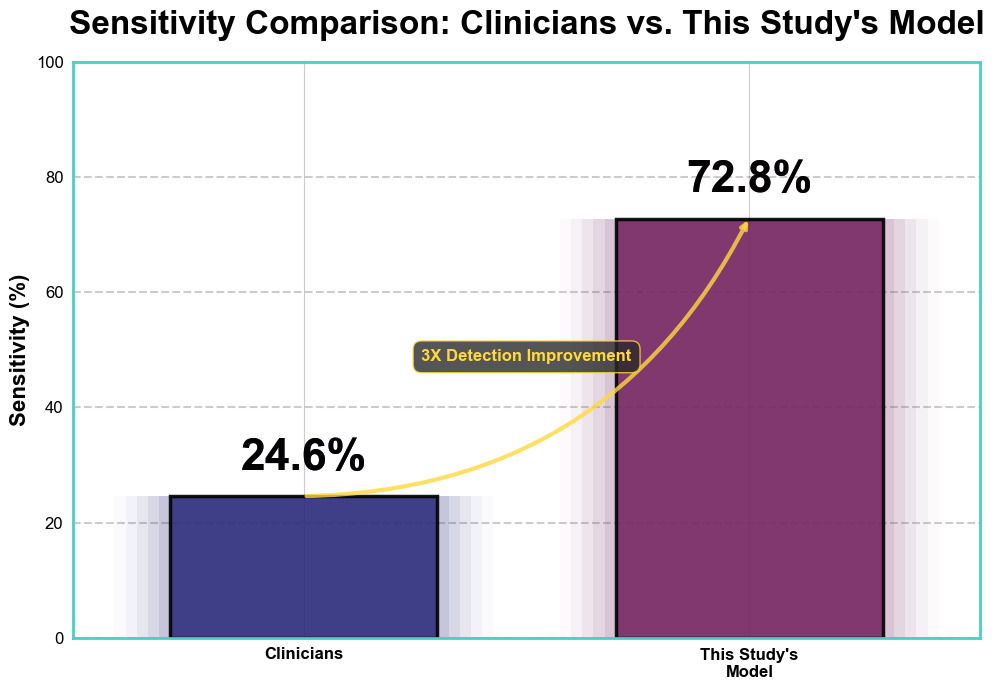

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set the style
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# Data
categories = ['Clinicians', "This Study's\nModel"]
sensitivities = [24.6, 72.8]

# Create a FIRE color palette - gradient from orange/red to bright green/cyan
colors = ["#2F307D", "#772964"]  # Coral red to turquoise

# Create figure with dark background for DRAMA
fig, ax = plt.subplots(figsize=(10, 7), facecolor="#ffffff")
ax.set_facecolor("#ffffff")

# Create bars with GLOW effect (multiple bars with decreasing alpha)
bar_width = 0.6
x_pos = np.arange(len(categories))

# Glow effect - draw multiple bars with increasing width and decreasing alpha
for glow in range(5, 0, -1):
    glow_alpha = 0.1 * (6 - glow) / 5
    ax.bar(x_pos, sensitivities, 
           width=bar_width + glow*0.05, 
           color=colors, 
           alpha=glow_alpha,
           edgecolor='none')

# Main bars with gradient effect
bars = ax.bar(x_pos, sensitivities, 
              width=bar_width,
              color=colors, 
              alpha=0.9,
              edgecolor='black', 
              linewidth=2.5)

# Add MASSIVE value labels with glow
for i, (bar, value) in enumerate(zip(bars, sensitivities)):
    height = bar.get_height()
    
    # Shadow/glow effect for text
    for offset in [(0, -2), (0, 2), (-2, 0), (2, 0)]:
        ax.text(bar.get_x() + bar.get_width()/2., height + 3,
                f'{value}%',
                ha='center', va='bottom', 
                fontsize=32, fontweight='bold',
                color=colors[i], alpha=0.3,
                transform=ax.transData)
    
    # Main text
    ax.text(bar.get_x() + bar.get_width()/2., height + 3,
            f'{value}%',
            ha='center', va='bottom', 
            fontsize=32, fontweight='bold',
            color='black')

# Customize plot with STYLE
ax.set_ylabel('Sensitivity (%)', fontsize=16, fontweight='bold', color='black')
ax.set_title('Sensitivity Comparison: Clinicians vs. This Study\'s Model', 
             fontsize=24, fontweight='bold', 
             pad=20, color='black')

ax.set_ylim(0, 100)
ax.set_yticks(np.arange(0, 101, 20))
ax.set_xticks(x_pos)
ax.set_xticklabels(categories, fontsize=14, fontweight='bold', color='black')

# Grid styling
ax.grid(axis='y', alpha=0.2, linestyle='--', color='black', linewidth=1.5)
ax.set_axisbelow(True)

# Spines styling
for spine in ax.spines.values():
    spine.set_edgecolor('#4ECDC4')
    spine.set_linewidth(2)

ax.tick_params(axis='both', which='major', labelsize=12, colors='black')
ax.tick_params(axis='y', colors='black')

# Add improvement arrow
arrow_props = dict(arrowstyle='->', 
                   connectionstyle='arc3,rad=0.3',
                   color='#FFD93D', 
                   lw=3,
                   alpha=0.8)
ax.annotate('', xy=(1, 73), xytext=(0, 24.6),
            arrowprops=arrow_props)
ax.text(0.5, 48, '3X Detection Improvement', 
        ha='center', fontsize=12, 
        color='#FFD93D', fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.5', 
                 facecolor='#2a2a2a', 
                 edgecolor='#FFD93D',
                 alpha=0.8))

plt.tight_layout()
plt.show()

## Theta/Alpha Ratio

In [7]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, pearsonr

# -------------------------------
# Configuration
# -------------------------------
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
ROI_FILE_SUFFIX = "_ROI_band_ratios.csv"
RATIO = "theta_alpha"

# Load subject info
meta = pd.read_csv(os.path.join(BASE_DIR, "participants.csv"))  # must have columns: participant_id, MOCA, GROUP

# Only PD subjects
PD_SUBS = meta.loc[meta['GROUP']=='PD', 'participant_id'].tolist()

# -------------------------------
# Collect ROI ratio values
# -------------------------------
roi_data = {}  # subj -> {roi: ratio}
for subj in PD_SUBS:
    roi_file = os.path.join(BASE_DIR, subj, "data", f"{subj}{ROI_FILE_SUFFIX}")
    if not os.path.exists(roi_file):
        print(f"{subj}: missing ROI file")
        continue
    df = pd.read_csv(roi_file)
    roi_data[subj] = dict(zip(df['roi'], df[RATIO]))

# -------------------------------
# Aggregate for group analysis
# -------------------------------
agg_vals = []
labels = []
moca_vals_list = []

for subj, roi_ratios in roi_data.items():
    moca_vals = meta.loc[meta['participant_id'] == subj, 'MOCA'].values
    if len(moca_vals) == 0 or np.isnan(moca_vals[0]):
        print(f"{subj}: missing MoCA, skipping")
        continue
    moca = moca_vals[0]

    # Average theta/alpha across all ROIs
    mean_ratio = np.mean(list(roi_ratios.values()))
    agg_vals.append(mean_ratio)
    labels.append(1 if moca < 26 else 0)  # 1 = impaired, 0 = unimpaired
    moca_vals_list.append(moca)

agg_vals = np.array(agg_vals)
labels = np.array(labels)
moca_vals_list = np.array(moca_vals_list)

# Split groups
impaired = agg_vals[labels == 1]
unimpaired = agg_vals[labels == 0]

# -------------------------------
# Stats
# -------------------------------
t, p = ttest_ind(impaired, unimpaired, equal_var=False)
r, p_corr = pearsonr(agg_vals, moca_vals_list)

print(f"Theta/Alpha ratio")
print(f"Cohort counts (PD only):")
print(f"  Total PD with MoCA+ROI: {len(agg_vals)}")
print(f"  Impaired (MoCA <26): {len(impaired)}")
print(f"  Unimpaired (MoCA >=26): {len(unimpaired)}\n")

print(f"Impaired: n={len(impaired)} | Mean={impaired.mean():.6f} | Std={impaired.std():.6f}")
print(f"Unimpaired: n={len(unimpaired)} | Mean={unimpaired.mean():.6f} | Std={unimpaired.std():.6f}\n")

print(f"--- Group comparison (Impaired vs Unimpaired) ---")
print(f"t = {t:.3f}, p = {p:.6g}")

print(f"\n--- Correlation (Theta/Alpha vs MoCA) across PD ---")
print(f"Pearson r = {r:.3f}, p = {p_corr:.6g}")

# -------------------------------
# Optional: Save aggregated ROI ratio data
# -------------------------------
np.save("PD_theta_alpha_ratio.npy", roi_data)
from statsmodels.stats.multitest import fdrcorrection

# Collect p-values
p_vals = np.array([p, p_corr])

# Benjamini–Hochberg FDR
rej, p_fdr = fdrcorrection(p_vals, alpha=0.05, method='indep')

p_t_fdr, p_corr_fdr = p_fdr

print(f"\n--- FDR-corrected results ---")
print(f"Group comparison: t = {t:.3f}, raw p = {p:.6g}, FDR p = {p_t_fdr:.6g}")
print(f"Correlation: Pearson r = {r:.3f}, raw p = {p_corr:.6g}, FDR p = {p_corr_fdr:.6g}")


Theta/Alpha ratio
Cohort counts (PD only):
  Total PD with MoCA+ROI: 100
  Impaired (MoCA <26): 53
  Unimpaired (MoCA >=26): 47

Impaired: n=53 | Mean=1.062811 | Std=0.637085
Unimpaired: n=47 | Mean=0.740235 | Std=0.388649

--- Group comparison (Impaired vs Unimpaired) ---
t = 3.063, p = 0.0029097

--- Correlation (Theta/Alpha vs MoCA) across PD ---
Pearson r = -0.467, p = 9.97801e-07

--- FDR-corrected results ---
Group comparison: t = 3.063, raw p = 0.0029097, FDR p = 0.0029097
Correlation: Pearson r = -0.467, raw p = 9.97801e-07, FDR p = 1.9956e-06


In [13]:
# -------------------------------
# Compute Cohen's d
# -------------------------------
mean_imp = impaired.mean()
mean_unimp = unimpaired.mean()
std_imp = impaired.std(ddof=1)
std_unimp = unimpaired.std(ddof=1)
n_imp = len(impaired)
n_unimp = len(unimpaired)

# Pooled standard deviation
pooled_std = np.sqrt(((n_imp - 1)*std_imp**2 + (n_unimp - 1)*std_unimp**2) / (n_imp + n_unimp - 2))
cohens_d = (mean_imp - mean_unimp) / pooled_std

print(f"\nCohen's d (Impaired vs Unimpaired) = {cohens_d:.3f}")



Cohen's d (Impaired vs Unimpaired) = 0.597


## Visualization

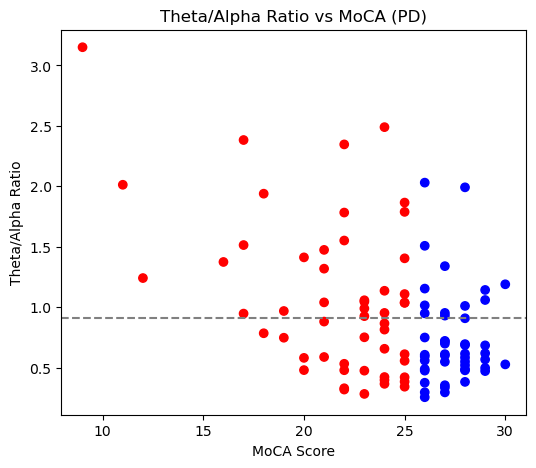

C:\Users\User\AppData\Local\Temp\ipykernel_19780\2194549600.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Theta_Alpha_Ratio', data=df_plot, palette='Pastel1', showfliers=False)


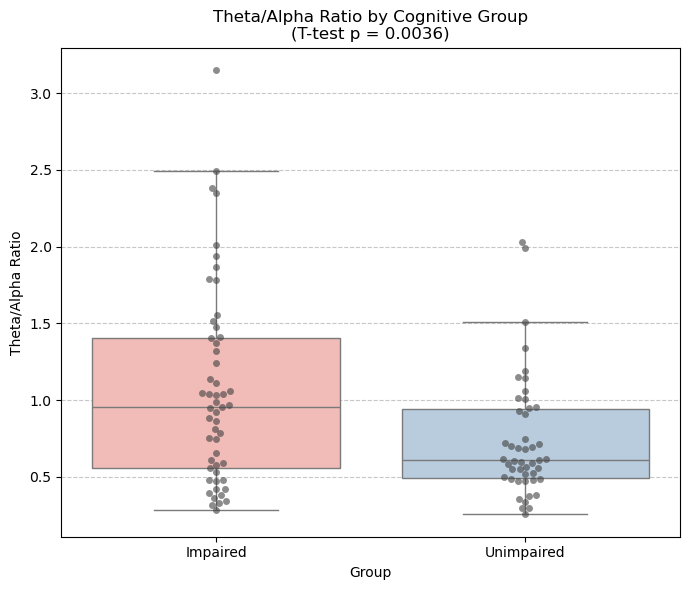

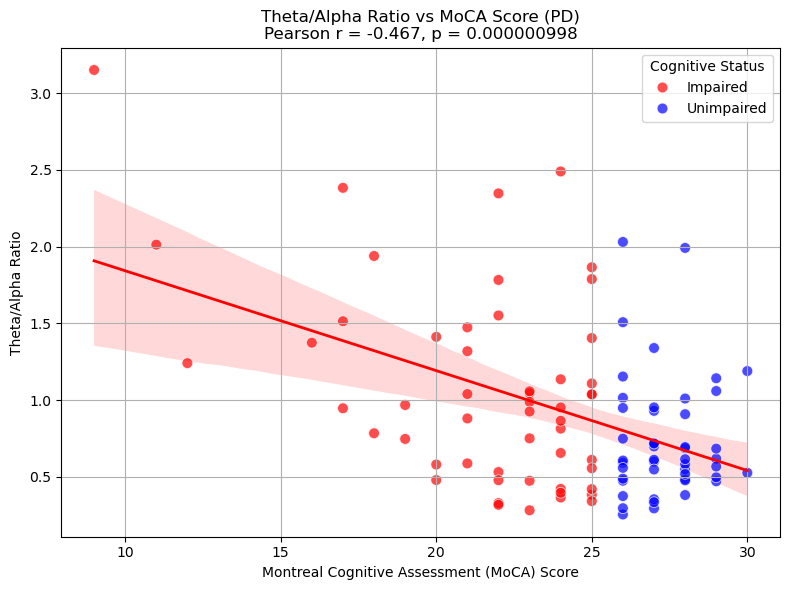

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare DataFrame
df_plot = pd.DataFrame({
    'theta_alpha': agg_vals,
    'MoCA_group': ['Impaired' if l==1 else 'Unimpaired' for l in labels]
})


plt.figure(figsize=(6,5))
plt.scatter(moca_vals_list, agg_vals, c=['red' if l==1 else 'blue' for l in labels])
plt.xlabel('MoCA Score')
plt.ylabel('Theta/Alpha Ratio')
plt.title('Theta/Alpha Ratio vs MoCA (PD)')
plt.axhline(y=agg_vals.mean(), color='gray', linestyle='--')
plt.show()
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# -------------------------------
# 1. Data Preparation
# -------------------------------
# Assuming agg_vals, labels, and moca_vals_list are already defined in your workspace
df_plot = pd.DataFrame({
    'MoCA_Score': moca_vals_list,
    'Theta_Alpha_Ratio': agg_vals,
    'Group': ['Impaired' if l == 1 else 'Unimpaired' for l in labels]
})

# -------------------------------
# 2. Boxplot with T-Test Comparison
# -------------------------------
plt.figure(figsize=(7, 6))

# Perform a t-test between groups for the title/annotation
group1 = df_plot[df_plot['Group'] == 'Impaired']['Theta_Alpha_Ratio']
group2 = df_plot[df_plot['Group'] == 'Unimpaired']['Theta_Alpha_Ratio']
t_stat, p_val_ttest = stats.ttest_ind(group1, group2)

sns.boxplot(x='Group', y='Theta_Alpha_Ratio', data=df_plot, palette='Pastel1', showfliers=False)
sns.swarmplot(x='Group', y='Theta_Alpha_Ratio', data=df_plot, color=".25", alpha=0.6)

plt.title(f'Theta/Alpha Ratio by Cognitive Group\n(T-test p = {p_val_ttest:.4f})')
plt.ylabel('Theta/Alpha Ratio')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# -------------------------------
# 3. Enhanced Scatter Plot with Regression
# -------------------------------
plt.figure(figsize=(8, 6))

# Calculate Pearson Correlation
r, p_val_corr = stats.pearsonr(df_plot['MoCA_Score'], df_plot['Theta_Alpha_Ratio'])

# Use regplot for the shaded confidence interval
sns.regplot(
    x='MoCA_Score', 
    y='Theta_Alpha_Ratio', 
    data=df_plot, 
    scatter=False, 
    color='red', 
    line_kws={"linewidth": 2}
)

# Overlay the individual points colored by group
sns.scatterplot(
    x='MoCA_Score', 
    y='Theta_Alpha_Ratio', 
    hue='Group', 
    data=df_plot, 
    palette={'Impaired': 'red', 'Unimpaired': 'blue'},
    s=60, 
    alpha=0.7
)

plt.title(f'Theta/Alpha Ratio vs MoCA Score (PD)\nPearson r = {r:.3f}, p = {p_val_corr:.9f}')
plt.xlabel('Montreal Cognitive Assessment (MoCA) Score')
plt.ylabel('Theta/Alpha Ratio')
plt.legend(title='Cognitive Status')
plt.grid(True)
plt.tight_layout()
plt.show()



# Delta/Beta

In [10]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, pearsonr

# -------------------------------
# Configuration
# -------------------------------
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
ROI_FILE_SUFFIX = "_ROI_band_ratios.csv"
RATIO = "delta_beta"  # change to delta/beta

# Load subject info
meta = pd.read_csv(os.path.join(BASE_DIR, "participants.csv"))  # must have columns: participant_id, MOCA, GROUP

# Only PD subjects
PD_SUBS = meta.loc[meta['GROUP']=='PD', 'participant_id'].tolist()

# -------------------------------
# Collect ROI ratio values
# -------------------------------
roi_data = {}  # subj -> {roi: ratio}
for subj in PD_SUBS:
    roi_file = os.path.join(BASE_DIR, subj, "data", f"{subj}{ROI_FILE_SUFFIX}")
    if not os.path.exists(roi_file):
        print(f"{subj}: missing ROI file")
        continue
    df = pd.read_csv(roi_file)
    # Compute delta/beta if not already computed
    if 'delta_beta' not in df.columns:
        df['delta_beta'] = df['delta_power'] / (df['beta_power'] + 1e-12)
    roi_data[subj] = dict(zip(df['roi'], df['delta_beta']))

# -------------------------------
# Aggregate for group analysis
# -------------------------------
agg_vals = []
labels = []
moca_vals_list = []

for subj, roi_ratios in roi_data.items():
    moca_vals = meta.loc[meta['participant_id'] == subj, 'MOCA'].values
    if len(moca_vals) == 0 or np.isnan(moca_vals[0]):
        print(f"{subj}: missing MoCA, skipping")
        continue
    moca = moca_vals[0]

    # Average delta/beta across all ROIs
    mean_ratio = np.mean(list(roi_ratios.values()))
    agg_vals.append(mean_ratio)
    labels.append(1 if moca < 26 else 0)  # 1 = impaired, 0 = unimpaired
    moca_vals_list.append(moca)

agg_vals = np.array(agg_vals)
labels = np.array(labels)
moca_vals_list = np.array(moca_vals_list)

# Split groups
impaired = agg_vals[labels == 1]
unimpaired = agg_vals[labels == 0]

# -------------------------------
# Stats
# -------------------------------
t, p = ttest_ind(impaired, unimpaired, equal_var=False)
r, p_corr = pearsonr(agg_vals, moca_vals_list)

print(f"Delta/Beta ratio")
print(f"Cohort counts (PD only):")
print(f"  Total PD with MoCA+ROI: {len(agg_vals)}")
print(f"  Impaired (MoCA <26): {len(impaired)}")
print(f"  Unimpaired (MoCA >=26): {len(unimpaired)}\n")

print(f"Impaired: n={len(impaired)} | Mean={impaired.mean():.6f} | Std={impaired.std():.6f}")
print(f"Unimpaired: n={len(unimpaired)} | Mean={unimpaired.mean():.6f} | Std={unimpaired.std():.6f}\n")

print(f"--- Group comparison (Impaired vs Unimpaired) ---")
print(f"t = {t:.3f}, p = {p:.6g}")

print(f"\n--- Correlation (Delta/Beta vs MoCA) across PD ---")
print(f"Pearson r = {r:.3f}, p = {p_corr:.6g}")

# -------------------------------
# Optional: Save aggregated ROI ratio data
# -------------------------------
np.save("PD_delta_beta_ratio.npy", roi_data)

from statsmodels.stats.multitest import fdrcorrection

# Collect p-values from group t-test and correlation
p_vals = np.array([p, p_corr])

# Apply Benjamini-Hochberg FDR
rej, p_fdr = fdrcorrection(p_vals, alpha=0.05, method='indep')

p_t_fdr, p_corr_fdr = p_fdr

print(f"\n--- FDR-corrected results ---")
print(f"Group comparison: t = {t:.3f}, raw p = {p:.6g}, FDR p = {p_t_fdr:.6g}")
print(f"Correlation: Pearson r = {r:.3f}, raw p = {p_corr:.6g}, FDR p = {p_corr_fdr:.6g}")


Delta/Beta ratio
Cohort counts (PD only):
  Total PD with MoCA+ROI: 100
  Impaired (MoCA <26): 53
  Unimpaired (MoCA >=26): 47

Impaired: n=53 | Mean=7.530779 | Std=5.657283
Unimpaired: n=47 | Mean=5.704582 | Std=4.435020

--- Group comparison (Impaired vs Unimpaired) ---
t = 1.788, p = 0.0768953

--- Correlation (Delta/Beta vs MoCA) across PD ---
Pearson r = -0.302, p = 0.00229992

--- FDR-corrected results ---
Group comparison: t = 1.788, raw p = 0.0768953, FDR p = 0.0768953
Correlation: Pearson r = -0.302, raw p = 0.00229992, FDR p = 0.00459985


## Visualization

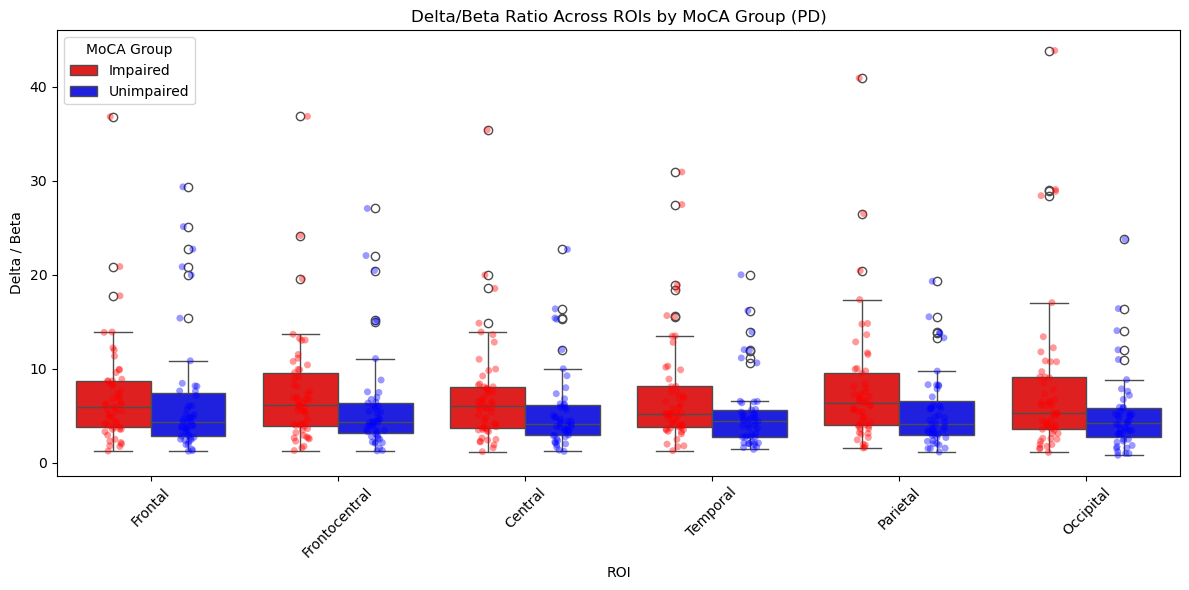

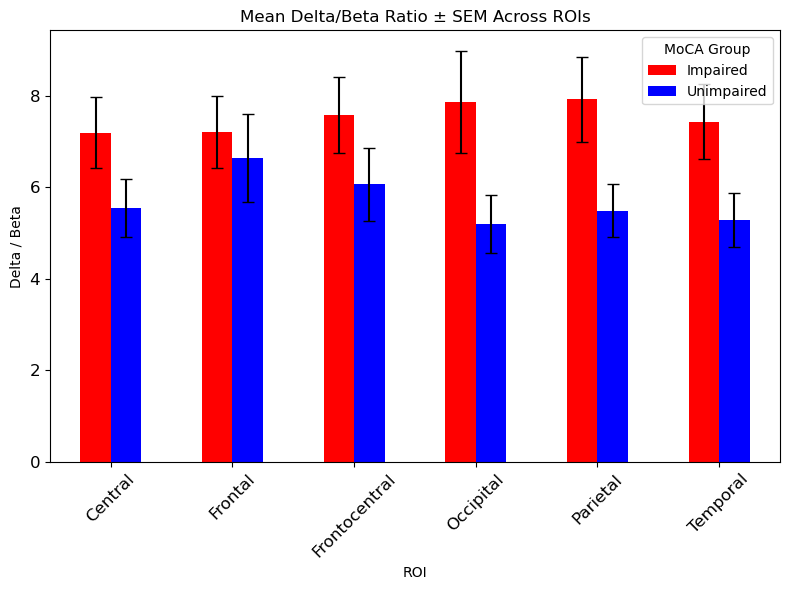

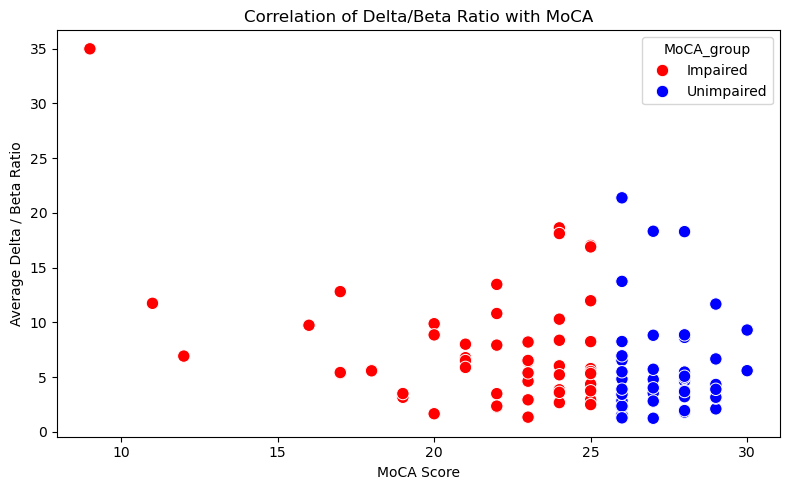

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Configuration
# -------------------------------
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
ROI_FILE_SUFFIX = "_ROI_band_ratios.csv"


# Consistent ratio definition: Delta / Beta
RATIO_NAME = "delta_beta"

palette = {
    'Impaired': 'red',
    'Unimpaired': 'blue'
}

# -------------------------------
# Load participant info
# -------------------------------
meta = pd.read_csv(os.path.join(BASE_DIR, "participants.csv"))
PD_SUBS = meta.loc[meta['GROUP'] == 'PD', 'participant_id'].tolist()

# -------------------------------
# Load ROI data
# -------------------------------
roi_data = {}
for subj in PD_SUBS:
    roi_file = os.path.join(BASE_DIR, subj, "data", f"{subj}{ROI_FILE_SUFFIX}")
    if not os.path.exists(roi_file):
        print(f"{subj}: missing ROI file")
        continue

    df = pd.read_csv(roi_file)

    # Create Delta/Beta if not present
    if RATIO_NAME not in df.columns:
        df[RATIO_NAME] = df['delta_power'] / (df['beta_power'] + 1e-12)

    roi_data[subj] = dict(zip(df['roi'], df[RATIO_NAME]))

# -------------------------------
# Convert to long-form DataFrame
# -------------------------------
rows = []
for subj, roi_dict in roi_data.items():
    moca_score = meta.loc[meta['participant_id'] == subj, 'MOCA'].values[0]
    group_label = 'Impaired' if moca_score < 26 else 'Unimpaired'

    for roi, val in roi_dict.items():
        rows.append({
            'subject': subj,
            'ROI': roi,
            'Ratio': val,
            'MoCA_group': group_label,
            'MOCA': moca_score
        })

df_long = pd.DataFrame(rows)

# -------------------------------
# 1) Boxplot + Stripplot per ROI
# -------------------------------
plt.figure(figsize=(12, 6))

sns.boxplot(
    x='ROI', y='Ratio',
    hue='MoCA_group',
    data=df_long,
    palette=palette
)

sns.stripplot(
    x='ROI', y='Ratio',
    hue='MoCA_group',
    data=df_long,
    dodge=True,
    palette=palette,
    alpha=0.4,
    legend=False
)

plt.title("Delta/Beta Ratio Across ROIs by MoCA Group (PD)")
plt.ylabel("Delta / Beta")
plt.xticks(rotation=45)
plt.legend(title="MoCA Group")
plt.tight_layout()
plt.show()

# -------------------------------
# 2) Bar plot (Mean ± SEM) per ROI
# -------------------------------
roi_means = df_long.groupby(['ROI', 'MoCA_group'])['Ratio'].mean().unstack()
roi_sems  = df_long.groupby(['ROI', 'MoCA_group'])['Ratio'].sem().unstack()

colors = [palette[col] for col in roi_means.columns]

roi_means.plot(
    kind='bar',
    yerr=roi_sems,
    figsize=(8, 6),
    capsize=4,
    color=colors
)

plt.ylabel("Delta / Beta")
plt.title("Mean Delta/Beta Ratio ± SEM Across ROIs")
plt.xticks(rotation=45)
plt.setp(plt.gca().get_xticklabels(), rotation=45, fontsize=12)
plt.setp(plt.gca().get_yticklabels(), fontsize=12)
plt.legend(title="MoCA Group")
plt.tight_layout()
plt.show()

# -------------------------------
# 3) Scatter: Average Ratio vs MoCA
# -------------------------------
avg_df = (
    df_long.groupby('subject')
    .agg({'Ratio': 'mean', 'MOCA': 'first', 'MoCA_group': 'first'})
    .reset_index()
)

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=avg_df,
    x='MOCA', y='Ratio',
    hue='MoCA_group',
    palette=palette,
    s=80
)

plt.xlabel("MoCA Score")
plt.ylabel("Average Delta / Beta Ratio")
plt.title("Correlation of Delta/Beta Ratio with MoCA")
plt.tight_layout()
plt.show()


# Dominant Posterior Background Frequency

### All posterior channels all subjects

In [1]:
import os
import numpy as np
import mne
from mne.time_frequency import psd_array_welch
import pandas as pd

# -------------------------------
# Config
# -------------------------------
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
SUBJECTS = [f"sub-{i:03d}" for i in range(1,130)]
POSTERIOR_CH = ['P3','P4','P7','P8','P6','P2','P5','P1','O1','O2','Oz','PO7','PO3','POz','PO4','PO8']
BANDS = {
    "delta": (1, 4),
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta": (13, 30)
}

# -------------------------------
# Loop over subjects
# -------------------------------
for subj in SUBJECTS:
    epo_file = os.path.join(BASE_DIR, subj, f"epo_{subj[-3:]}_raw.fif")
    if not os.path.exists(epo_file):
        print(f"{subj}: missing epochs file")
        continue

    epochs = mne.read_epochs(epo_file, preload=True, verbose=False)
    ch_names = [ch.upper() for ch in epochs.ch_names]
    idx_post = [ch_names.index(ch) for ch in POSTERIOR_CH if ch in ch_names]
    if not idx_post:
        print(f"{subj}: no posterior channels found, skipping")
        continue

    data_post = epochs.get_data()[:, idx_post, :]  # only posterior channels
    sfreq = epochs.info['sfreq']
    n_times = data_post.shape[-1]
    n_per_seg = min(int(sfreq*2), n_times)

    dpbf_results = []

    for band_name, (fmin, fmax) in BANDS.items():
        psds, freqs = psd_array_welch(
            data_post, sfreq=sfreq, fmin=fmin, fmax=fmax,
            n_fft=2048, n_per_seg=n_per_seg, average='mean', verbose=False
        )

        psd_mean = psds.mean(axis=(0,1))  # across epochs and posterior channels
        band_mask = (freqs >= fmin) & (freqs <= fmax)
        band_psd = psd_mean[band_mask]
        band_freqs = freqs[band_mask]

        dpbf = band_freqs[np.argmax(band_psd)] if len(band_psd) > 0 else np.nan
        dpbf_results.append({'subject': subj, 'band': band_name, 'dpbf': dpbf})

    df_dpbf = pd.DataFrame(dpbf_results)
    out_file = os.path.join(BASE_DIR, subj, f"{subj}_Posterior_DPBF.csv")
    df_dpbf.to_csv(out_file, index=False)
    print(f"{subj}: saved posterior DPBF → {out_file}")


C:\Users\User\AppData\Local\Temp\ipykernel_33300\1125240128.py:29: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-001\epo_001_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_file, preload=True, verbose=False)


sub-001: saved posterior DPBF → C:\Users\User\Documents\EEG_Project\rEEG\sub-001\sub-001_Posterior_DPBF.csv


C:\Users\User\AppData\Local\Temp\ipykernel_33300\1125240128.py:29: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-002\epo_002_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_file, preload=True, verbose=False)


sub-002: saved posterior DPBF → C:\Users\User\Documents\EEG_Project\rEEG\sub-002\sub-002_Posterior_DPBF.csv


C:\Users\User\AppData\Local\Temp\ipykernel_33300\1125240128.py:29: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-003\epo_003_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_file, preload=True, verbose=False)


sub-003: saved posterior DPBF → C:\Users\User\Documents\EEG_Project\rEEG\sub-003\sub-003_Posterior_DPBF.csv


C:\Users\User\AppData\Local\Temp\ipykernel_33300\1125240128.py:29: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-004\epo_004_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_file, preload=True, verbose=False)


KeyboardInterrupt: 

### 8 channels

In [ ]:
import os
import numpy as np
import mne
from mne.time_frequency import psd_array_welch
import pandas as pd

# -------------------------------
# Config
# -------------------------------
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
SUBJECTS = [f"sub-{i:03d}" for i in range(1,100)]
# POSTERIOR_CH = ['P3','P4','Oz']
POSTERIOR_CH = ['P3','P4','Oz','O2','O1','POz','P2','P4']
BANDS = {
    "delta": (1, 4),
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta": (13, 30)
}

# -------------------------------
# Loop over subjects
# -------------------------------
for subj in SUBJECTS:
    epo_file = os.path.join(BASE_DIR, subj, f"epo_{subj[-3:]}_raw.fif")
    if not os.path.exists(epo_file):
        print(f"{subj}: missing epochs file")
        continue

    epochs = mne.read_epochs(epo_file, preload=True, verbose=False)
    ch_names = [ch.upper() for ch in epochs.ch_names]
    idx_post = [ch_names.index(ch) for ch in POSTERIOR_CH if ch in ch_names]
    if not idx_post:
        print(f"{subj}: no posterior channels found, skipping")
        continue

    data_post = epochs.get_data()[:, idx_post, :]  # only posterior channels
    sfreq = epochs.info['sfreq']
    n_times = data_post.shape[-1]
    n_per_seg = min(int(sfreq*2), n_times)

    dpbf_results = []

    for band_name, (fmin, fmax) in BANDS.items():
        psds, freqs = psd_array_welch(
            data_post, sfreq=sfreq, fmin=fmin, fmax=fmax,
            n_fft=2048, n_per_seg=n_per_seg, average='mean', verbose=False
        )

        psd_mean = psds.mean(axis=(0,1))  # across epochs and posterior channels
        band_mask = (freqs >= fmin) & (freqs <= fmax)
        band_psd = psd_mean[band_mask]
        band_freqs = freqs[band_mask]

        dpbf = band_freqs[np.argmax(band_psd)] if len(band_psd) > 0 else np.nan
        dpbf_results.append({'subject': subj, 'band': band_name, 'dpbf': dpbf})

    df_dpbf = pd.DataFrame(dpbf_results)
    out_file = os.path.join(BASE_DIR, subj, f"{subj}_middle_Posterior_DPBF.csv")
    df_dpbf.to_csv(out_file, index=False)
    print(f"{subj}: saved posterior DPBF → {out_file}")


### Check for statistical significance

In [5]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, pearsonr

# -------------------------------
# Config
# -------------------------------
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
DPBF_SUFFIX = "_middle_Posterior_DPBF.csv"
BANDS = ["delta", "theta", "alpha", "beta"]

# Load metadata
meta = pd.read_csv(os.path.join(BASE_DIR, "participants.csv"))

# PD subjects only
PD_SUBS = meta.loc[meta["GROUP"] == "PD", "participant_id"].tolist()

# -------------------------------
# Load DPBF data
# -------------------------------
records = []

for subj in PD_SUBS:
    fpath = os.path.join(BASE_DIR, subj, f"{subj}{DPBF_SUFFIX}")
    if not os.path.exists(fpath):
        continue

    df = pd.read_csv(fpath)
    moca_vals = meta.loc[meta["participant_id"] == subj, "MOCA"].values
    if len(moca_vals) == 0 or np.isnan(moca_vals[0]):
        continue

    moca = moca_vals[0]

    for _, row in df.iterrows():
        records.append({
            "subject": subj,
            "band": row["band"],
            "dpbf": row["dpbf"],
            "moca": moca,
            "impaired": int(moca < 26)
        })

df_all = pd.DataFrame(records)



### Statistical Test (MAIN ONE FOR DPBF)

In [6]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, pearsonr

# -------------------------------
# Config
# -------------------------------
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
DPBF_SUFFIX = "_Posterior_DPBF.csv"
BANDS = ["delta", "theta", "alpha", "beta"]

# Load metadata
meta = pd.read_csv(os.path.join(BASE_DIR, "participants.csv"))

# PD subjects only
PD_SUBS = meta.loc[meta["GROUP"] == "PD", "participant_id"].tolist()

# -------------------------------
# Load DPBF data
# -------------------------------
records = []

for subj in PD_SUBS:
    fpath = os.path.join(BASE_DIR, subj, f"{subj}{DPBF_SUFFIX}")
    if not os.path.exists(fpath):
        continue

    df = pd.read_csv(fpath)

    moca_vals = meta.loc[meta["participant_id"] == subj, "MOCA"].values
    if len(moca_vals) == 0 or np.isnan(moca_vals[0]):
        continue

    moca = moca_vals[0]

    for _, row in df.iterrows():
        records.append({
            "subject": subj,
            "band": row["band"],
            "dpbf": row["dpbf"],
            "moca": moca,
            "impaired": int(moca < 26)
        })

from scipy.stats import ttest_ind, pearsonr, spearmanr
import numpy as np

# -------------------------------
# Stats per band
# -------------------------------
n_permutations = 5000  # for permutation correlation

for band in BANDS:
    df_band = df_all[df_all["band"] == band]

    impaired = df_band[df_band["impaired"] == 1]["dpbf"].values
    unimpaired = df_band[df_band["impaired"] == 0]["dpbf"].values

    if len(impaired) < 10 or len(unimpaired) < 10:
        print(f"\n{band.upper()}: insufficient data")
        continue

    # Group comparison
    t, p_group = ttest_ind(impaired, unimpaired, equal_var=False)

    # Pearson correlation
    r_pearson, p_pearson = pearsonr(df_band["dpbf"], df_band["moca"])

    # Spearman correlation
    r_spearman, p_spearman = spearmanr(df_band["dpbf"], df_band["moca"])

    # Permutation test for Pearson correlation
    perm_r = []
    moca_vals = df_band["moca"].values
    dpbf_vals = df_band["dpbf"].values
    for _ in range(n_permutations):
        np.random.shuffle(moca_vals)
        perm_r.append(np.corrcoef(dpbf_vals, moca_vals)[0, 1])
    perm_r = np.array(perm_r)
    p_perm = (np.sum(np.abs(perm_r) >= np.abs(r_pearson)) + 1) / (n_permutations + 1)

    print(f"\nPosterior DPBF (P3/P4/Oz/O2/O1/POz/P2/P4) – {band.upper()}")
    print(f"PD count: {len(df_band)}")
    print(f"Impaired (MoCA <26): n={len(impaired)} | mean={impaired.mean():.3f}")
    print(f"Unimpaired (MoCA ≥26): n={len(unimpaired)} | mean={unimpaired.mean():.3f}")
    print(f"Group diff: t={t:.3f}, p={p_group:.6g}")
    print(f"Pearson r vs MoCA: r={r_pearson:.3f}, p={p_pearson:.6g}")
    print(f"Spearman r vs MoCA: r={r_spearman:.3f}, p={p_spearman:.6g}")
    print(f"Permutation p (Pearson): p={p_perm:.6g}")






Posterior DPBF (P3/P4/Oz/O2/O1/POz/P2/P4) – DELTA
PD count: 100
Impaired (MoCA <26): n=53 | mean=1.112
Unimpaired (MoCA ≥26): n=47 | mean=1.101
Group diff: t=1.264, p=0.210839
Pearson r vs MoCA: r=0.051, p=0.611997
Spearman r vs MoCA: r=0.054, p=0.594089
Permutation p (Pearson): p=0.608478

Posterior DPBF (P3/P4/Oz/O2/O1/POz/P2/P4) – THETA
PD count: 100
Impaired (MoCA <26): n=53 | mean=6.771
Unimpaired (MoCA ≥26): n=47 | mean=6.774
Group diff: t=-0.008, p=0.993905
Pearson r vs MoCA: r=0.117, p=0.244988
Spearman r vs MoCA: r=0.164, p=0.102109
Permutation p (Pearson): p=0.25175

Posterior DPBF (P3/P4/Oz/O2/O1/POz/P2/P4) – ALPHA
PD count: 100
Impaired (MoCA <26): n=53 | mean=8.720
Unimpaired (MoCA ≥26): n=47 | mean=9.189
Group diff: t=-2.010, p=0.0476587
Pearson r vs MoCA: r=0.200, p=0.0458682
Spearman r vs MoCA: r=0.247, p=0.0131362
Permutation p (Pearson): p=0.0465907

Posterior DPBF (P3/P4/Oz/O2/O1/POz/P2/P4) – BETA
PD count: 100
Impaired (MoCA <26): n=53 | mean=15.282
Unimpaired (MoC

C:\Users\User\AppData\Local\Temp\ipykernel_33300\3959073765.py:26: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-001\epo_001_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_file, preload=True, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_33300\3959073765.py:26: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-002\epo_002_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_file, preload=True, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_33300\3959073765.py:26: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-003\epo_003_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep

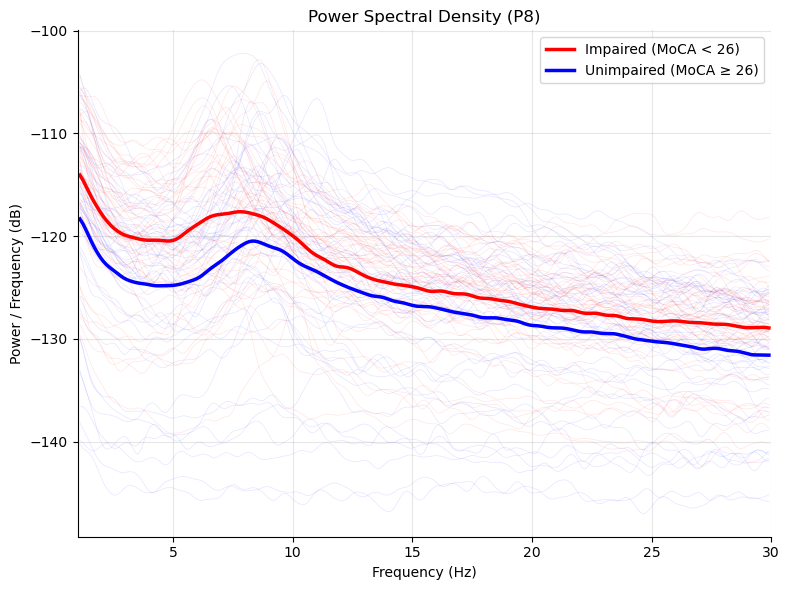

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.time_frequency import psd_array_welch

# -------------------------------
# Plotting Config
# -------------------------------
TARGET_CH = 'P8'
FMIN, FMAX = 1, 30

# Storage for plotting
all_psds = []
all_groups = []
freqs_plot = None

# -------------------------------
# Loop through PD subjects
# -------------------------------
for subj in PD_SUBS:
    epo_file = os.path.join(BASE_DIR, subj, f"epo_{subj[-3:]}_raw.fif")
    if not os.path.exists(epo_file):
        continue

    epochs = mne.read_epochs(epo_file, preload=True, verbose=False)
    
    # Standardize channel names
    ch_names = [ch.upper() for ch in epochs.ch_names]
    if TARGET_CH not in ch_names:
        continue
    
    # Get MoCA score and assign group color
    moca_val = meta.loc[meta["participant_id"] == subj, "MOCA"].values[0]
    group_color = 'red' if moca_val < 26 else 'blue'
    
    # Extract data for target channel
    ch_idx = ch_names.index(TARGET_CH)
    data = epochs.get_data()[:, ch_idx, :]  # shape: (n_epochs, n_times)
    
    # Compute PSD
    n_per_seg = min(int(epochs.info['sfreq']*2), data.shape[-1])
    psds, freqs = psd_array_welch(
        data,
        sfreq=epochs.info['sfreq'],
        fmin=FMIN, fmax=FMAX,
        n_fft=2048,
        n_per_seg=n_per_seg,
        verbose=False
    )
    
    # Average across epochs and convert to dB
    psd_db = 10 * np.log10(psds.mean(axis=0))
    
    all_psds.append(psd_db)
    all_groups.append(group_color)
    freqs_plot = freqs  # safe because all PSDs share same freq vector

# Convert to arrays for indexing
all_psds = np.array(all_psds)
all_groups = np.array(all_groups, dtype=object)

# -------------------------------
# Plot
# -------------------------------
plt.figure(figsize=(8, 6))

# Individual PSD lines (transparent)
for i in range(len(all_psds)):
    plt.plot(freqs_plot, all_psds[i], color=all_groups[i], alpha=0.1, linewidth=0.5)

# Group means
for color, label in [('red', 'Impaired (MoCA < 26)'), ('blue', 'Unimpaired (MoCA ≥ 26)')]:
    if np.any(all_groups == color):  # only plot if group exists
        mean_psd = all_psds[all_groups == color].mean(axis=0)
        plt.plot(freqs_plot, mean_psd, color=color, linewidth=2.5, label=label)

plt.title(f"Power Spectral Density ({TARGET_CH})")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power / Frequency (dB)")
plt.xlim(FMIN, FMAX)
plt.grid(True, alpha=0.3)
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


### Frontal and posterior EEG connectivity all bands

In [5]:
import os
import numpy as np
import mne
import pandas as pd
from scipy.stats import ttest_ind, spearmanr

# -------------------------------
# Config
# -------------------------------
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
META_PATH = "participants.csv"

meta = pd.read_csv(META_PATH)
MOCA_COL = 'MOCA' if 'MOCA' in meta.columns else 'MoCA'
PD_SUBS = meta.loc[meta['GROUP'] == 'PD', 'participant_id'].tolist()

BANDS = ["delta", "theta", "alpha", "beta"]

# Frontal and Posterior Hubs
FRONTAL_CH = ['FZ','F3','F4','F7','F8','FP1','FP2','FC1','FC2','AF7','AF3','AFz','AF4','AF8']
POSTERIOR_CH = ['P3','P4','P7','P8','P6','P2','P5','P1','O1','O2','Oz','PO7','PO3','POz','PO4','PO8']

# -------------------------------
# Helpers
# -------------------------------
def get_channel_indices(subj):
    subj_num = subj.split('-')[-1]
    epo_path = os.path.join(BASE_DIR, subj, f"epo_{subj_num}_raw.fif")
    
    if not os.path.exists(epo_path):
        return None, None
        
    epochs = mne.read_epochs(epo_path, preload=False, verbose=False)
    chs = [c.upper() for c in epochs.ch_names]
    
    f_idx = [chs.index(c) for c in FRONTAL_CH if c in chs]
    p_idx = [chs.index(c) for c in POSTERIOR_CH if c in chs]
    return f_idx, p_idx

def upper_mean(mat):
    if mat.size == 0: 
        return np.nan
    iu = np.triu_indices_from(mat, k=1)
    return np.nanmean(mat[iu])

# -------------------------------
# Main Analysis
# -------------------------------
# Step 1: Cache channel indices once
print("Caching channel indices...")
subj_cache = {}
for subj in PD_SUBS:
    f_idx, p_idx = get_channel_indices(subj)
    if f_idx and p_idx and len(f_idx) > 1 and len(p_idx) > 1:
        subj_cache[subj] = (f_idx, p_idx)

results = []

# Step 2: Loop through each band
for band in BANDS:
    print(f"Processing {band} band...")
    data_store = []

    for subj, (f_idx, p_idx) in subj_cache.items():
        mat_path = os.path.join(BASE_DIR, subj, "data", f"{subj}_{band}_pli_matrix.npy")
        if not os.path.exists(mat_path):
            continue

        mat = np.load(mat_path)

        # Ensure matrix is symmetric
        if np.allclose(mat, np.tril(mat)) or np.allclose(mat, np.triu(mat)):
            mat = mat + mat.T - np.diag(np.diag(mat))

        f_mean = upper_mean(mat[np.ix_(f_idx, f_idx)])
        p_mean = upper_mean(mat[np.ix_(p_idx, p_idx)])
        
        moca_val = meta.loc[meta['participant_id'] == subj, MOCA_COL].values[0]

        if not np.isnan(f_mean) and not np.isnan(p_mean) and not np.isnan(moca_val):
            data_store.append({
                'band': band,
                'frontal': f_mean,
                'posterior': p_mean,
                'delta': f_mean - p_mean,
                'moca': moca_val,
                'label': 1 if moca_val < 26 else 0
            })

    # Convert to DataFrame and compute statistics per band
    if data_store:
        df_band = pd.DataFrame(data_store)

        for metric in ['frontal', 'posterior', 'delta']:
            imp = df_band.loc[df_band['label'] == 1, metric]
            unimp = df_band.loc[df_band['label'] == 0, metric]

            mean_imp, std_imp = imp.mean(), imp.std()
            mean_unimp, std_unimp = unimp.mean(), unimp.std()
            t, p_group = ttest_ind(imp, unimp, equal_var=False)
            rho, p_corr = spearmanr(df_band[metric], df_band['moca'])

            results.append({
                "band": band,
                "metric": metric,
                "n_total": len(df_band),
                "mean_impaired": mean_imp,
                "std_impaired": std_imp,
                "mean_unimpaired": mean_unimp,
                "std_unimpaired": std_unimp,
                "t_stat": t,
                "p_group": p_group,
                "rho_MoCA": rho,
                "p_corr": p_corr
            })

# -------------------------------
# Output Results
# -------------------------------
if results:
    final_df = pd.DataFrame(results)
    final_df = final_df.sort_values("p_corr")
    print("\n--- Summary of Statistically Significant Features ---")
    print(final_df)
    final_df.to_csv("PD_feature_selection_results.csv", index=False)
else:
    print("No results were generated. Check file paths and MoCA column names.")


Caching channel indices...


C:\Users\User\AppData\Local\Temp\ipykernel_12856\1236058771.py:33: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-001\epo_001_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path, preload=False, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_12856\1236058771.py:33: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-002\epo_002_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path, preload=False, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_12856\1236058771.py:33: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-003\epo_003_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  

Processing delta band...
Processing theta band...
Processing alpha band...
Processing beta band...

--- Summary of Statistically Significant Features ---
     band     metric  n_total  mean_impaired  std_impaired  mean_unimpaired  \
9    beta    frontal      100       0.100305      0.012443         0.110527   
7   alpha  posterior      100       0.107606      0.020722         0.116266   
11   beta      delta      100      -0.002746      0.009838         0.001420   
1   delta  posterior      100       0.099295      0.013959         0.104636   
10   beta  posterior      100       0.103051      0.013616         0.109108   
8   alpha      delta      100       0.013950      0.027079         0.009929   
2   delta      delta      100       0.005525      0.014787         0.000703   
6   alpha    frontal      100       0.121555      0.030388         0.126195   
5   theta      delta      100       0.008233      0.029891         0.002114   
3   theta    frontal      100       0.120695      0.0310

In [1]:
import os
import numpy as np
import mne
import pandas as pd
from scipy.stats import ttest_ind, spearmanr

# -------------------------------
# Config
# -------------------------------
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
META_PATH = r"C:\Users\User\Documents\EEG_Project\participants.csv"

meta = pd.read_csv(META_PATH)
MOCA_COL = 'MOCA' if 'MOCA' in meta.columns else 'MoCA'
PD_SUBS = meta.loc[meta['GROUP'] == 'PD', 'participant_id'].tolist()

# Only beta band
BANDS = ["beta"]

# Frontal and Posterior Hubs
FRONTAL_CH = ['FZ','F3','F4','F7','F8','FP1','FP2','FC1','FC2','AF7','AF3','AFz','AF4','AF8']
POSTERIOR_CH = ['P3','P4','P7','P8','P6','P2','P5','P1','O1','O2','Oz','PO7','PO3','POz','PO4','PO8']

# -------------------------------
# Helpers
# -------------------------------
def get_channel_indices(subj):
    subj_num = subj.split('-')[-1]
    epo_path = os.path.join(BASE_DIR, subj, f"epo_{subj_num}_raw.fif")
    
    if not os.path.exists(epo_path):
        return None, None
        
    epochs = mne.read_epochs(epo_path, preload=False, verbose=False)
    chs = [c.upper() for c in epochs.ch_names]
    
    f_idx = [chs.index(c) for c in FRONTAL_CH if c in chs]
    p_idx = [chs.index(c) for c in POSTERIOR_CH if c in chs]
    return f_idx, p_idx

def upper_mean(mat):
    if mat.size == 0: 
        return np.nan
    iu = np.triu_indices_from(mat, k=1)
    return np.nanmean(mat[iu])

def cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    return (np.mean(group1) - np.mean(group2)) / pooled_std

# -------------------------------
# Main Analysis
# -------------------------------
# Step 1: Cache channel indices once
print("Caching channel indices...")
subj_cache = {}
for subj in PD_SUBS:
    f_idx, p_idx = get_channel_indices(subj)
    if f_idx and p_idx and len(f_idx) > 1 and len(p_idx) > 1:
        subj_cache[subj] = (f_idx, p_idx)

results = []

# Step 2: Process beta band only
for band in BANDS:
    print(f"Processing {band} band...")
    data_store = []

    for subj, (f_idx, p_idx) in subj_cache.items():
        mat_path = os.path.join(BASE_DIR, subj, "data", f"{subj}_{band}_pli_matrix.npy")
        if not os.path.exists(mat_path):
            continue

        mat = np.load(mat_path)

        # Ensure matrix is symmetric
        if np.allclose(mat, np.tril(mat)) or np.allclose(mat, np.triu(mat)):
            mat = mat + mat.T - np.diag(np.diag(mat))

        f_mean = upper_mean(mat[np.ix_(f_idx, f_idx)])
        p_mean = upper_mean(mat[np.ix_(p_idx, p_idx)])
        
        moca_val = meta.loc[meta['participant_id'] == subj, MOCA_COL].values[0]

        if not np.isnan(f_mean) and not np.isnan(p_mean) and not np.isnan(moca_val):
            data_store.append({
                'band': band,
                'delta': f_mean - p_mean,
                'moca': moca_val,
                'label': 1 if moca_val < 26 else 0
            })

    # Convert to DataFrame and compute statistics
    if data_store:
        df_band = pd.DataFrame(data_store)

        # Only compute for delta metric
        metric = 'delta'
        imp = df_band.loc[df_band['label'] == 1, metric]
        unimp = df_band.loc[df_band['label'] == 0, metric]

        mean_imp, std_imp = imp.mean(), imp.std()
        mean_unimp, std_unimp = unimp.mean(), unimp.std()
        t, p_group = ttest_ind(imp, unimp, equal_var=False)
        rho, p_corr = spearmanr(df_band[metric], df_band['moca'])
        
        # Calculate Cohen's d
        cohens_d_value = cohens_d(imp, unimp)

        results.append({
            "band": band,
            "metric": metric,
            "n_total": len(df_band),
            "n_impaired": len(imp),
            "n_unimpaired": len(unimp),
            "mean_impaired": mean_imp,
            "std_impaired": std_imp,
            "mean_unimpaired": mean_unimp,
            "std_unimpaired": std_unimp,
            "t_stat": t,
            "p_group": p_group,
            "cohens_d": cohens_d_value,
            "rho_MoCA": rho,
            "p_corr": p_corr
        })

# -------------------------------
# Output Results
# -------------------------------
if results:
    final_df = pd.DataFrame(results)
    print("\n--- Beta Band Delta (Frontal - Posterior) Analysis ---")
    print(final_df.to_string(index=False))
    final_df.to_csv("PD_beta_delta_results.csv", index=False)
else:
    print("No results were generated. Check file paths and MoCA column names.")

Caching channel indices...


C:\Users\User\AppData\Local\Temp\ipykernel_6540\1447257000.py:34: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-001\epo_001_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path, preload=False, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_6540\1447257000.py:34: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-002\epo_002_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path, preload=False, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_6540\1447257000.py:34: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-003\epo_003_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epo

Processing beta band...

--- Beta Band Delta (Frontal - Posterior) Analysis ---
band metric  n_total  n_impaired  n_unimpaired  mean_impaired  std_impaired  mean_unimpaired  std_unimpaired    t_stat  p_group  cohens_d  rho_MoCA   p_corr
beta  delta      100          53            47      -0.002746      0.009838          0.00142        0.013785 -1.719302 0.089327 -0.351338  0.174184 0.083058


Reading C:\Users\User\Documents\EEG_Project\rEEG\sub-001\epo_001_raw.fif ...
    Found the data of interest:
        t =       0.00 ...    4000.00 ms
        0 CTF compensation matrices available


C:\Users\User\AppData\Local\Temp\ipykernel_12856\522207224.py:46: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-001\epo_001_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  info = mne.read_epochs(epo_path, preload=False).info


Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated


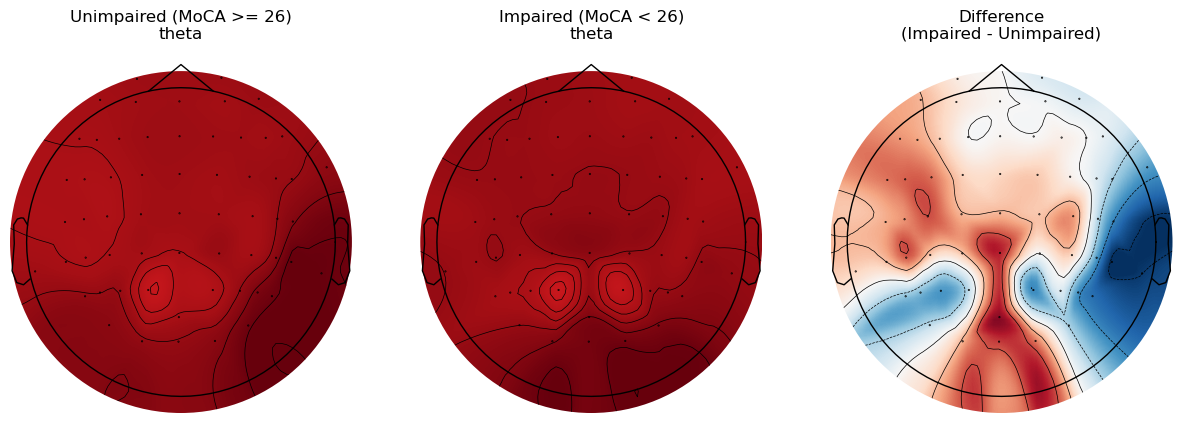

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import mne
import pandas as pd
from scipy.stats import ttest_ind, spearmanr

# -------------------------------
# Config
# -------------------------------
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
meta = pd.read_csv("participants.csv")

# Ensure we use the correct column name for MoCA
MOCA_COL = 'MOCA' if 'MOCA' in meta.columns else 'MoCA'
PD_SUBS = meta.loc[meta['GROUP'] == 'PD', 'participant_id'].tolist()

BANDS = ["delta", "theta", "alpha", "beta"]
def plot_group_topomap(band_name, subj_cache, meta, MOCA_COL, BASE_DIR):
    # 1. Separate subjects by group
    impaired_subs = meta.loc[(meta['GROUP'] == 'PD') & (meta[MOCA_COL] < 26), 'participant_id'].tolist()
    unimpaired_subs = meta.loc[(meta['GROUP'] == 'PD') & (meta[MOCA_COL] >= 26), 'participant_id'].tolist()

    def get_avg_conn(sub_list):
        all_mats = []
        for subj in sub_list:
            mat_path = os.path.join(BASE_DIR, subj, "data", f"{subj}_{band_name}_pli_matrix.npy")
            if os.path.exists(mat_path):
                mat = np.load(mat_path)
                # Make symmetric if needed
                if np.allclose(mat, np.tril(mat)) or np.allclose(mat, np.triu(mat)):
                    mat = mat + mat.T - np.diag(np.diag(mat))
                # Nodal connectivity: average of all connections for each channel
                all_mats.append(np.nanmean(mat, axis=1))
        return np.mean(all_mats, axis=0)

    # 2. Compute means
    mean_imp = get_avg_conn(impaired_subs)
    mean_unimp = get_avg_conn(unimpaired_subs)
    diff = mean_imp - mean_unimp

    # 3. Get Info/Layout from a sample file
    sample_sub = PD_SUBS[0]
    subj_num = sample_sub.split('-')[-1]
    epo_path = os.path.join(BASE_DIR, sample_sub, f"epo_{subj_num}_raw.fif")
    info = mne.read_epochs(epo_path, preload=False).info

    # 4. Plotting
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Set common color limits for comparison
    vmax = max(np.abs(mean_imp).max(), np.abs(mean_unimp).max())
    
    mne.viz.plot_topomap(mean_unimp, info, axes=axes[0], show=False, vlim=(0, vmax))
    axes[0].set_title(f'Unimpaired (MoCA >= 26)\n{band_name}')

    mne.viz.plot_topomap(mean_imp, info, axes=axes[1], show=False, vlim=(0, vmax))
    axes[1].set_title(f'Impaired (MoCA < 26)\n{band_name}')

    mne.viz.plot_topomap(diff, info, axes=axes[2], show=False, cmap='RdBu_r')
    axes[2].set_title(f'Difference\n(Impaired - Unimpaired)')

    plt.show()

# Example call for your significant Beta band
plot_group_topomap("theta", PD_SUBS, meta, MOCA_COL, BASE_DIR)